## NAB Corpus

##### The NAB corpus of 58 timeseries data files is designed to provide data for research in streaming anomaly detection. It is comprised of both real-world and artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics. All data files contain anomalies, unless otherwise noted.
https://www.kaggle.com/datasets/boltzmannbrain/nab

##### The majority of the data is real-world from a variety of sources such as AWS server metrics, Twitter volume, advertisement clicking metrics, traffic data, and more. All data is included in the repository, with more details in the data readme

##### realKnownCause:

This is data for which we know the anomaly causes; no hand labeling.

ambient_temperature_system_failure.csv: The ambient temperature in an office
setting.

Labels: https://github.com/numenta/NAB/blob/master/labels/combined_labels.json


In [341]:
!git clone https://github.com/Nardeen-99/NAB-Corpus.git

fatal: destination path 'NAB-Corpus' already exists and is not an empty directory.


In [342]:
!pip install pyod

In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
from pyod.models.mad import MAD
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [344]:
raw_df = pd.read_csv("/content/ambient_temperature_system_failure.csv")
raw_df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [345]:
df = raw_df.copy()
df

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


In [346]:
# change the timestamp attribute data type
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df.dtypes)

timestamp    datetime64[ns]
value               float64
dtype: object


In [347]:
# labels taken from the link above , we are looking at the labels for "realKnownCause/ambient_temperature_system_failure.csv"
anomalies_timestamp = [ "2013-12-22 20:00:00",
                        "2014-04-13 09:00:00"
]

In [348]:
df['is_anomaly'] = 1
df.head()

,timestamp,value,is_anomaly
0,2013-07-04 00:00:00,69.880835,1
1,2013-07-04 01:00:00,71.220227,1
2,2013-07-04 02:00:00,70.877805,1
3,2013-07-04 03:00:00,68.959400,1
4,2013-07-04 04:00:00,69.283551,1


In [349]:
for i in anomalies_timestamp:
  df.loc[df['timestamp'] == i, 'is_anomaly'] = -1

In [350]:
df['is_anomaly'].value_counts()

 1    7265
-1       2
Name: is_anomaly, dtype: int64

In [351]:
inlier = df.loc[df['is_anomaly'] == 1]
inlier

,timestamp,value,is_anomaly
0,2013-07-04 00:00:00,69.880835,1
1,2013-07-04 01:00:00,71.220227,1
2,2013-07-04 02:00:00,70.877805,1
3,2013-07-04 03:00:00,68.959400,1
4,2013-07-04 04:00:00,69.283551,1
...,...,...,...
7262,2014-05-28 11:00:00,72.370206,1
7263,2014-05-28 12:00:00,72.172956,1
7264,2014-05-28 13:00:00,72.046565,1
7265,2014-05-28 14:00:00,71.825226,1


In [352]:
outlier = df.loc[df['is_anomaly'] == -1]
outlier

,timestamp,value,is_anomaly
3721,2013-12-22 20:00:00,86.204189,-1
6180,2014-04-13 09:00:00,57.458406,-1


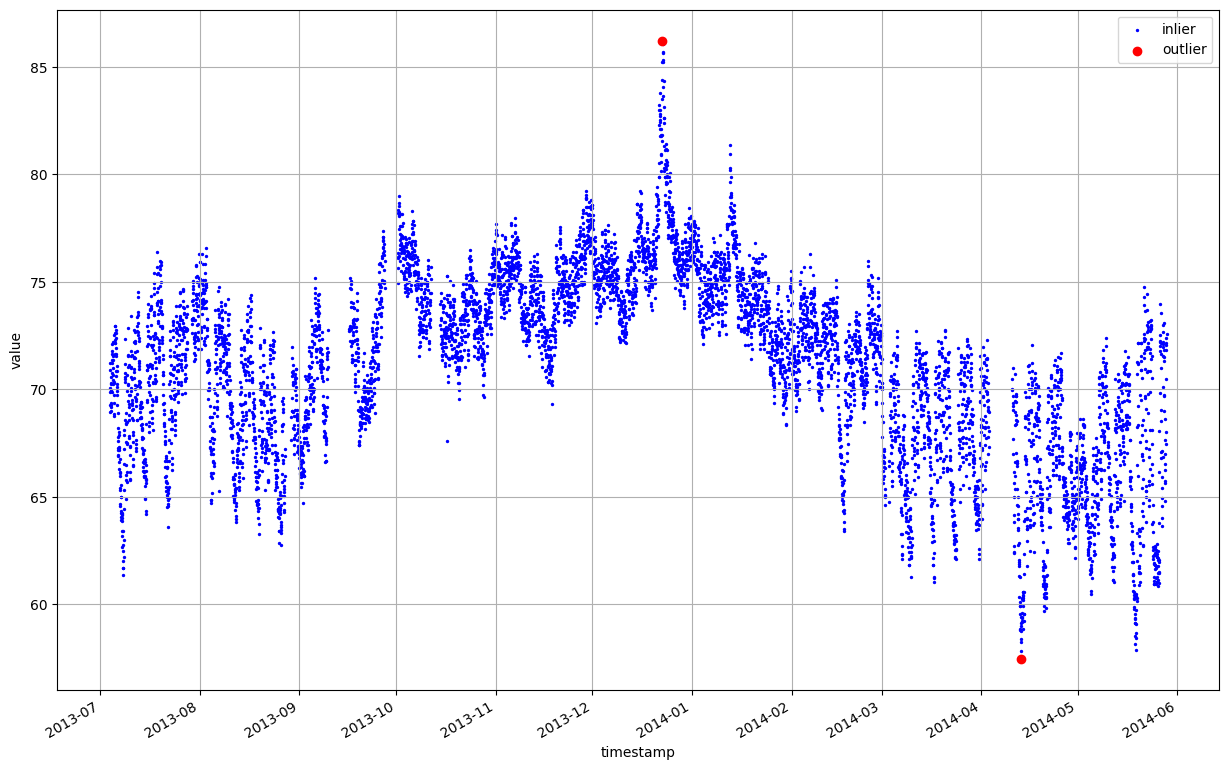

In [353]:
fig, ax = plt.subplots()
ax.scatter(inlier.timestamp, inlier['value'], color = 'blue', s=2, label = 'inlier')
ax.scatter(outlier.timestamp, outlier['value'], color = 'red', label = 'outlier')
ax.set_xlabel('timestamp')
ax.set_ylabel('value')
ax.legend()
ax.grid(True)
fig.autofmt_xdate()
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

The red points are the outliers

In [354]:
(df.loc[df['is_anomaly'] == -1])

,timestamp,value,is_anomaly
3721,2013-12-22 20:00:00,86.204189,-1
6180,2014-04-13 09:00:00,57.458406,-1


In [355]:
# Calculate the outlier rate over the entire data to compare it with the model prediction
df_outlier_rate = len(df.loc[df['is_anomaly'] == -1]) / len(df)
print('the outlier rate is : ', df_outlier_rate)

the outlier rate is :  0.0002752167331773772


### I would like to try to use The Median Absolute Deviation as the median is such a robust statistic on the contrary of the mean aand standard deviation

The MAD is the median of the absolute difference between a value and the median of the sample.

## MAD

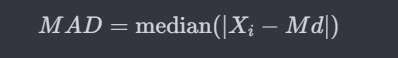

In [356]:
def calculate_MAD (value):
  # Calculate the Median (Md)
  median = df['value'].median()
  # Compute Absolute Deviations
  # 1- Subtract the median from each data point
  sub =  np.abs(df['value'] - median)
  # 2- Calculate the absolute deviations from the median
  # 3- Find the median of the absolute deviations calculated in step 2.
  MAD = np.median(sub)
  return MAD

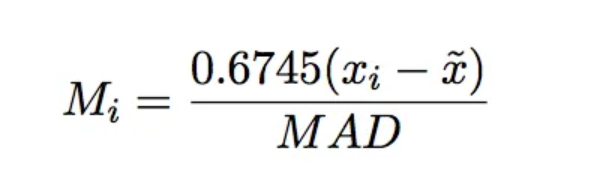

In [357]:
def Modified_z_score(value):
  return 0.6745 * (df['value'] - df['value'].median()) / df['value'].apply(calculate_MAD)

In [358]:
df['MAD'] = Modified_z_score(df['value'])
df

,timestamp,value,is_anomaly,MAD
0,2013-07-04 00:00:00,69.880835,1,-0.454188
1,2013-07-04 01:00:00,71.220227,1,-0.146584
2,2013-07-04 02:00:00,70.877805,1,-0.225224
3,2013-07-04 03:00:00,68.959400,1,-0.665804
4,2013-07-04 04:00:00,69.283551,1,-0.591359
...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,1,0.117520
7263,2014-05-28 12:00:00,72.172956,1,0.072219
7264,2014-05-28 13:00:00,72.046565,1,0.043193
7265,2014-05-28 14:00:00,71.825226,1,-0.007640


Now we can calculate the score for each point of our sample!, we’ll use the score of 3 as our cut-off value; This means that every point with a score above 3 will be considered an outlier.

In [359]:
df['baseline'] = 1

In [360]:
df.loc[df['MAD'] >= 3, 'baseline'] = -1
df.loc[df['MAD'] <= -3, 'baseline'] = -1
df.head()

,timestamp,value,is_anomaly,MAD,baseline
0,2013-07-04 00:00:00,69.880835,1,-0.454188,1
1,2013-07-04 01:00:00,71.220227,1,-0.146584,1
2,2013-07-04 02:00:00,70.877805,1,-0.225224,1
3,2013-07-04 03:00:00,68.959400,1,-0.665804,1
4,2013-07-04 04:00:00,69.283551,1,-0.591359,1


In [361]:
df.baseline.value_counts()

 1    7247
-1      20
Name: baseline, dtype: int64

### Performance measurement

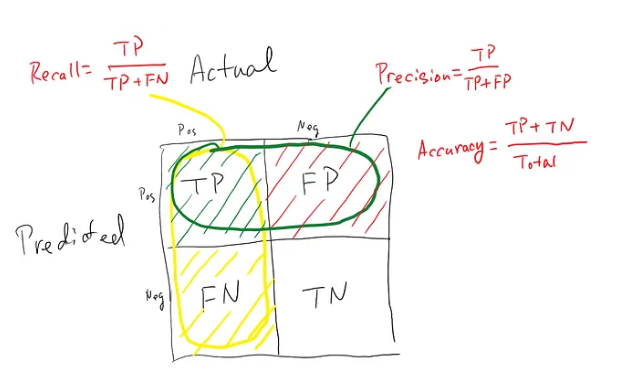

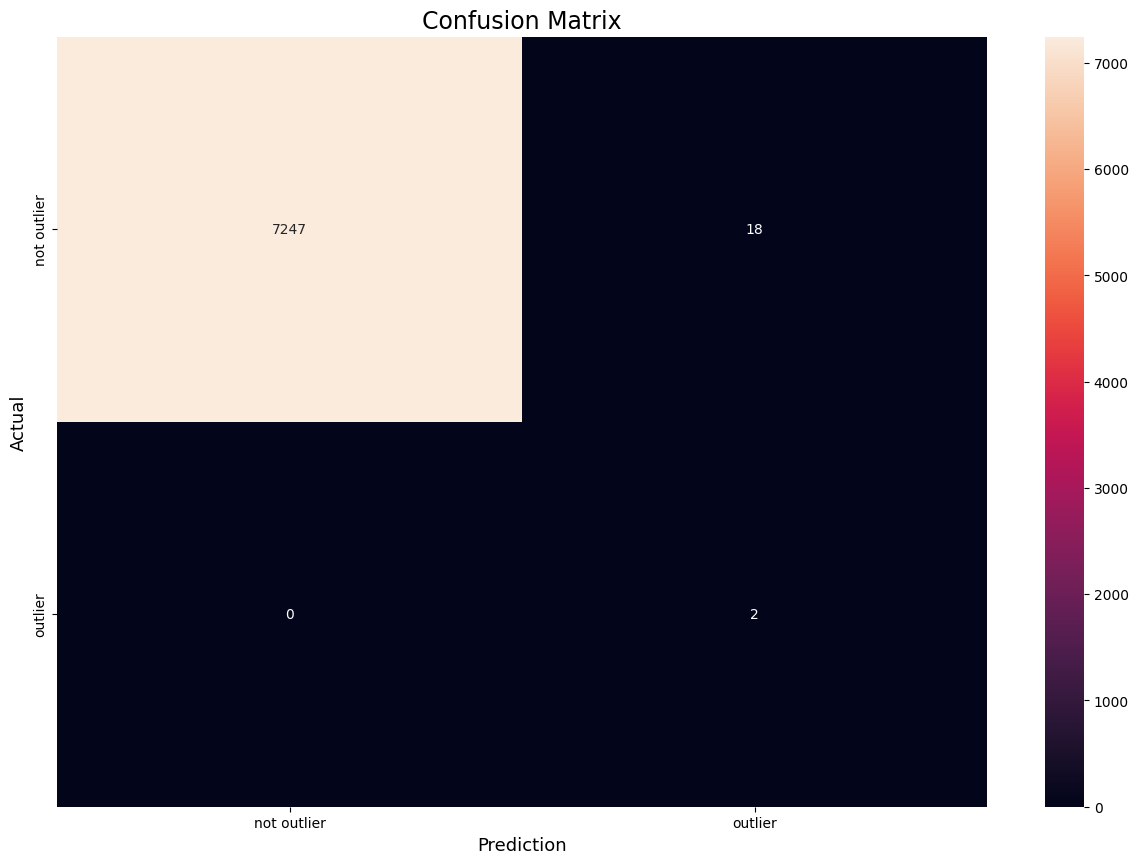

In [362]:
actual = df['is_anomaly']
predicted = df['baseline']
cm = confusion_matrix(actual, predicted, labels=[1, -1])
sns.heatmap(cm,
			annot=True,
			fmt='g',
			xticklabels=['not outlier','outlier'],
			yticklabels=['not outlier','outlier'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

- The models performance is quite good because the number of values that we predicted as not an outlier and it was actually an outlier (FP) = 0

- and the (TP) : represents True Positive (outliers correctly predicted as outliers) = 2 (the already two known outliers)

## Isolation forest


In [363]:
df.set_index('timestamp', inplace=True)

In [364]:
# we need to split the data in the way of keeping one outlier in the x_train and the other one in x_test
X = df
X_train, X_test = train_test_split(X, test_size= 0.25 ,random_state=1)

In [365]:
X_train.is_anomaly.value_counts()

 1    5449
-1       1
Name: is_anomaly, dtype: int64

In [366]:
X_test.is_anomaly.value_counts()

 1    1816
-1       1
Name: is_anomaly, dtype: int64

In [367]:
X_train

,value,is_anomaly,MAD,baseline
timestamp,,,,
2013-12-19 07:00:00,75.062323,1,0.735790,1
2013-07-18 06:00:00,69.537913,1,-0.532943,1
2014-04-24 01:00:00,68.252653,1,-0.828115,1
2014-01-09 10:00:00,72.669481,1,0.186251,1
2013-12-21 18:00:00,80.520263,1,1.989256,1
...,...,...,...,...
2013-08-12 01:00:00,65.296042,1,-1.507128,1
2014-02-22 03:00:00,71.880749,1,0.005111,1
2014-01-02 15:00:00,75.455554,1,0.826099,1


In [368]:
X_train = X_train['value'].values.reshape(-1, 1)
X_train

array([[75.06232298],
       [69.53791299],
       [68.25265298],
       ...,
       [75.45555433],
       [69.40509502],
       [72.02762569]])

In [369]:
X_test['value']

timestamp
2013-12-01 21:00:00    77.098628
2013-12-06 12:00:00    74.529987
2014-01-31 23:00:00    74.618803
2013-11-06 00:00:00    77.148409
2013-10-06 13:00:00    76.452504
                         ...    
2014-04-13 21:00:00    60.383213
2014-01-30 14:00:00    71.815960
2013-07-13 05:00:00    71.294426
2014-04-22 00:00:00    65.796425
2014-02-22 01:00:00    71.324592
Name: value, Length: 1817, dtype: float64

In [370]:
# manually hyperparameter tuning
contamination = [0.001, 0.0002, 0.0003, 0.004, 0.005, 0.1]
for i in contamination:
  model = IsolationForest(contamination=i, random_state=42)
  model.fit(X_train)
  labels = model.predict(X_test['value'].values.reshape(-1,1))
  outlier_rate = (labels == -1).sum() / len(labels)
  print('outlier rate for the {0} kernel is: {1}'.format(i, outlier_rate))

outlier rate for the 0.001 kernel is: 0.001100715465052284
outlier rate for the 0.0002 kernel is: 0.001100715465052284
outlier rate for the 0.0003 kernel is: 0.001100715465052284
outlier rate for the 0.004 kernel is: 0.003302146395156852
outlier rate for the 0.005 kernel is: 0.003852504127682994
outlier rate for the 0.1 kernel is: 0.09356081452944413


In [371]:
labels = labels.reshape(-1, 1)
labels

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [372]:
len(X_test)

1817

In [373]:
labels.size

1817

In [374]:
# That means about 0.0003 of the data is an actual outlier
df_outlier_rate

0.0002752167331773772

In [375]:
model = IsolationForest(contamination= 0.0003, random_state=42)
model.fit(X_train)
labels = model.predict(X_test['value'].values.reshape(-1,1))

### Performance measurement

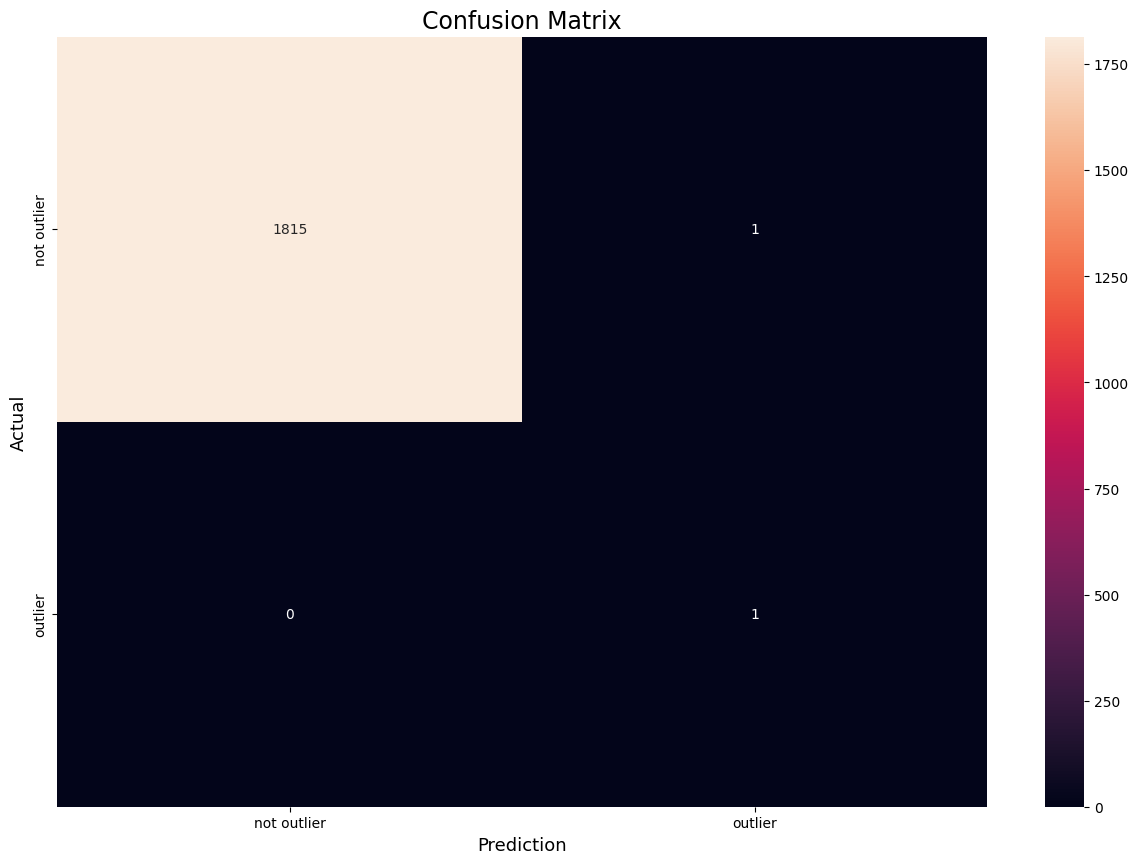

In [376]:
actual = X_test['is_anomaly']
predicted = labels
cm = confusion_matrix(actual, predicted, labels=[1, -1])
sns.heatmap(cm,
			annot=True,
			fmt='g',
			xticklabels=['not outlier','outlier'],
			yticklabels=['not outlier','outlier'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

- The model here misleaded a little bit , as the number of values that have been predicted as outliers and there were actually outliers (TP)= 1 but we have 2 actual outliers

In [377]:
import pickle
with open('Isolation_Forest.pkl', 'wb') as f:
    pickle.dump(model, f)

## Local Outlier Factor

In [378]:
X['is_anomaly']= X['is_anomaly'].values.reshape(-1, 1)
X['is_anomaly']

timestamp
2013-07-04 00:00:00    1
2013-07-04 01:00:00    1
2013-07-04 02:00:00    1
2013-07-04 03:00:00    1
2013-07-04 04:00:00    1
                      ..
2014-05-28 11:00:00    1
2014-05-28 12:00:00    1
2014-05-28 13:00:00    1
2014-05-28 14:00:00    1
2014-05-28 15:00:00    1
Name: is_anomaly, Length: 7267, dtype: int64

In [379]:
X['value']= X['value'].values.reshape(-1, 1)
X['value']

timestamp
2013-07-04 00:00:00    69.880835
2013-07-04 01:00:00    71.220227
2013-07-04 02:00:00    70.877805
2013-07-04 03:00:00    68.959400
2013-07-04 04:00:00    69.283551
                         ...    
2014-05-28 11:00:00    72.370206
2014-05-28 12:00:00    72.172956
2014-05-28 13:00:00    72.046565
2014-05-28 14:00:00    71.825226
2014-05-28 15:00:00    72.584089
Name: value, Length: 7267, dtype: float64

In [380]:
n_neighbors = [20, 25, 30, 35]
for _ in n_neighbors:
  model = LocalOutlierFactor(n_neighbors=_ , contamination=0.0003)
  y_pred = model.fit_predict(X['value'].values.reshape(-1, 1))
  y_pred = y_pred.reshape(-1, 1)
  silhouette_avg = silhouette_score(y_pred, X['is_anomaly'])
  print('Silhouette Score for the {0} n_neighbors: {1}'.format(_, silhouette_avg))

Silhouette Score for the 20 n_neighbors: 0.9986240110561367
Silhouette Score for the 25 n_neighbors: 0.9986240110561367
Silhouette Score for the 30 n_neighbors: 0.9995871749002336
Silhouette Score for the 35 n_neighbors: 0.9995871749002336


In [381]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [382]:
model = LocalOutlierFactor(n_neighbors=20, contamination=0.0003)
y_pred = model.fit_predict(X)
y_pred = y_pred.reshape(-1,1)
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [383]:
X_test.shape

(1817, 4)

In [384]:
y_pred.size

7267

### Performance measurement

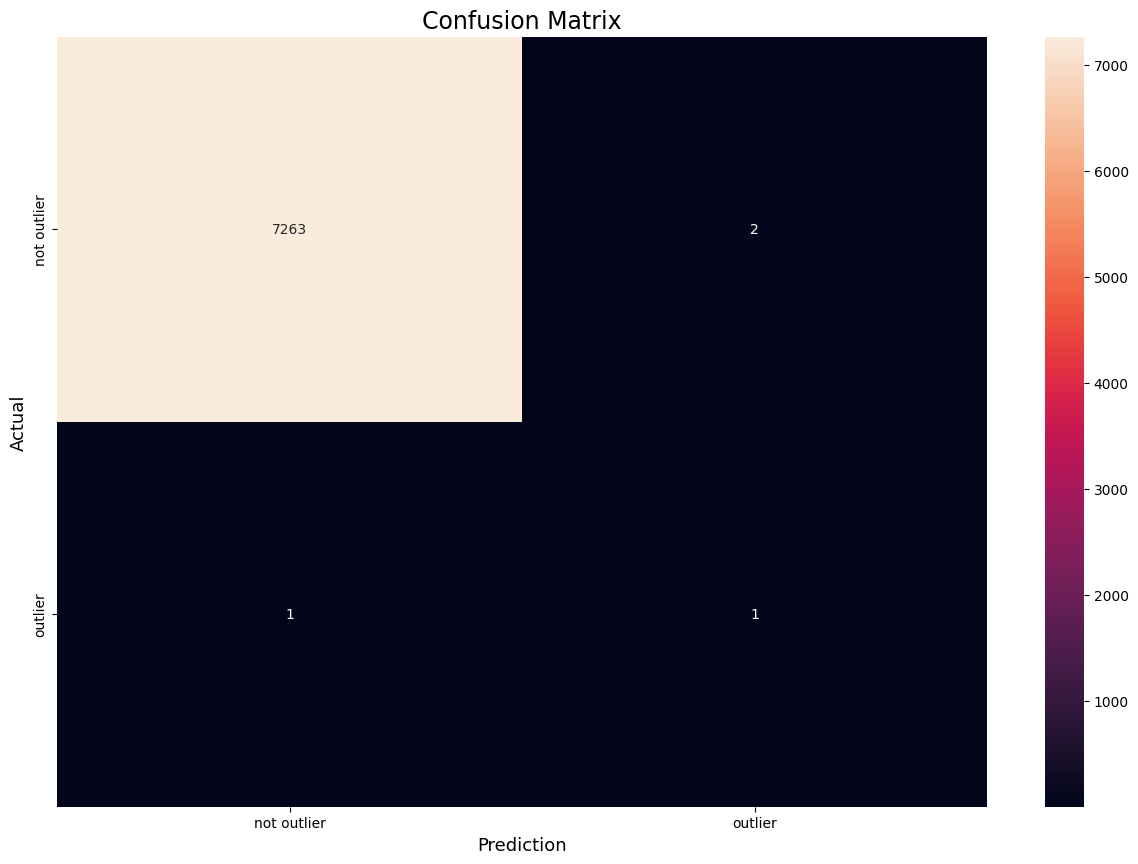

In [385]:
actual = X['is_anomaly']
predicted = y_pred
cm = confusion_matrix(actual, predicted, labels=[1, -1])
sns.heatmap(cm,
			annot=True,
			fmt='g',
			xticklabels=['not outlier','outlier'],
			yticklabels=['not outlier','outlier'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

- This is the worst model evaluation as the model misleaded the (FP) situation, we have a data point that was predicted as not outlier and it were actually an outlier

In [386]:
import pickle
with open('Local_Outlier_Factor.pkl', 'wb') as f:
    pickle.dump(model, f)

## Conclusion:
- The best model performance was with MAD and robust Z_score as it succed to detect the two know aoutliers

- The models performance is quite good because the number of values that we predicted as not an outlier and it was actually an outlier (FP) = 0

- And the (TP) : represents True Positive (outliers correctly predicted as outliers) = 2 (the already two known outliers)

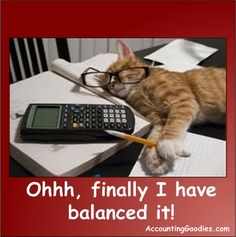

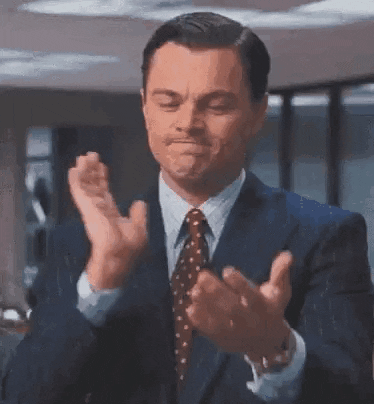